In [1]:
# import libraries
import numpy as np
import pandas as pd
import json
import ast
import PIL
from PIL import Image
import subprocess
import time
import math
from collections import namedtuple
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, rmsprop
from keras import backend as K
from keras.callbacks import EarlyStopping
import matplotlib
%matplotlib inline
import seaborn as sns
import h5py as h5py
sns.set_style('white')

Using TensorFlow backend.


**Assemble Data For Training:**

In [2]:
# load initial movie data frame
movie_df = pd.read_csv('movie_df.csv')

In [2]:
# load image data frame
image_df = pd.read_csv('image_df.csv')

In [4]:
# load text 
text_df = pd.read_csv('text_df.csv')

In [5]:
## identify and remove movies with no poster ##

# remove movies with no genre class
image_df = image_df[(movie_df['genre_class'] != 'None')]
text_df = text_df[(movie_df['genre_class'] != 'None')]
movie_df = movie_df[(movie_df['genre_class'] != 'None')]

# remove movies with no poster
image_df = image_df[(movie_df['poster_path'] != None)]
text_df = text_df[(movie_df['poster_path'] != None)]
movie_df = movie_df[(movie_df['poster_path'] != None)]
image_df = image_df[(pd.notnull(movie_df['poster_path']))]
text_df = text_df[(pd.notnull(movie_df['poster_path']))]
movie_df = movie_df[(pd.notnull(movie_df['poster_path']))]

full_df = pd.concat([movie_df['genre_class'], image_df, text_df], axis = 1)

In [6]:
# split into train and test sets
mask = np.random.rand(len(full_df)) < .8

train = full_df[mask]
test = full_df[~mask]

genres = list(set(train['genre_class']))

# oversample undersampled classes
for i in range(len(genres)):
    
    genre_mask = (train['genre_class'] == str(genres[i]))
    
    select_genre = train[genre_mask]
    
    oversamp = select_genre.sample(1000, replace = True)
    
    if i == 0:
        
        final_train = oversamp
        
    else:
        
        final_train = pd.concat([final_train, oversamp])
        
# shuffle final dataset
fina_train = final_train.sample(frac = 1, replace = False)
        
train_x = final_train.iloc[:, 1:1025]
train_x_text = final_train.iloc[:, 1025:]
train_y = final_train.iloc[:, 0]
test_x = test.iloc[:, 1:1025]
test_x_text = test.iloc[:, 1025:]
test_y = test.iloc[:, 0]

In [7]:
## create matrix of RBG tuples from train_x

## create matrix from image_df
image_mat_str = np.array(train_x)

# initialize list
x = []

# for each image
for k in range(len(train_x)):
    
    # create matrix for individual image
    image = np.zeros((32, 32), dtype = (int, 3))
    
    # for each image row
    for i in range(32):
        
        # for each image column
        for j in range(32):
            
            # get string of RBG array
            pixel_str = image_mat_str[k, (j + i*32)]
            
            # transform string into array and store
            image[i, j] = np.array(ast.literal_eval(pixel_str))
    
    # append to list
    x.append(image)
    
# turn list to matrix and reshape for CNN
x = np.asarray(x)
train_x = x.reshape(x.shape[0], 3, 32, 32)
print(np.shape(train_x))

(7000, 3, 32, 32)


In [8]:
## create matrix of RBG tuples from train_x

## create matrix from image_df
image_mat_str = np.array(test_x)

# initialize list
x = []

# for each image
for k in range(len(test_x)):
    
    # create matrix for individual image
    image = np.zeros((32, 32), dtype = (int, 3))
    
    # for each image row
    for i in range(32):
        
        # for each image column
        for j in range(32):
            
            # get string of RBG array
            pixel_str = image_mat_str[k, (j + i*32)]
            
            # transform string into array and store
            image[i, j] = np.array(ast.literal_eval(pixel_str))
 
    # append to list
    x.append(image)
    
# turn list to matrix and reshape for CNN
x = np.asarray(x)
test_x = x.reshape(x.shape[0], 3, 32, 32)
print(np.shape(test_x))

(2200, 3, 32, 32)


In [9]:
## normalize image values
# (drawn from lab)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255
print('train_x shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
print(test_x.shape[0], 'test samples')

train_x shape: (7000, 3, 32, 32)
7000 train samples
2200 test samples


In [10]:
## convert string classes to integer classes

# for train_y
train_y_num = []

for i in train_y:
    
    train_y_num.append(genres.index(i))
    
train_y = np.array(train_y_num, dtype = int)

# for test_y
test_y_num = []

for i in test_y:
    
    test_y_num.append(genres.index(i))
    
test_y = np.array(test_y_num, dtype = int)

In [11]:
## convert classes to binary (drawn from lab)

train_y = keras.utils.to_categorical(train_y, 7)
test_y = keras.utils.to_categorical(test_y, 7)

**Train Scratch Model:**

In [21]:
## model from scratch
# (ideas generally sourced from lecture, lab and
# https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# empty network model
model = Sequential()


# INPUT LAYER #

# 2D convolution layer
model.add(Conv2D(32, 
                 (3, 3), 
                 padding = 'same',
                 input_shape = train_x.shape[1:],
                 activation = 'relu'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                      data_format = 'channels_first'))
# dropout
model.add(Dropout(0.2))



# HIDDEN LAYER #

# 2D convolution layer
model.add(Conv2D(64, 
                 (3, 3), 
                 padding = 'same'))
# max pooling
model.add(MaxPooling2D(pool_size = (2, 2),
                       data_format = 'channels_first'))
# dropout
model.add(Dropout(0.2))


# FLATTEN #

model.add(Flatten())


# FC LAYER #

# first regularization
model.add(Dense(64, 
                activation = 'relu'))
# dropout
model.add(Dropout(0.5))
# second regularization
model.add(Dense(7, 
                activation = 'softmax'))

# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 3, 32, 32)         9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 16, 16)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 16, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 16, 64)         9280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 8, 32)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)               0         
__________

In [27]:
## control settings, optimizer, compiling, and early stopping
# (sourced from lecture, lab and https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py)

# optimizer
rms_opt = rmsprop(lr = 0.0001, 
                  decay = 1e-6)

# compile model
model.compile(loss = 'categorical_crossentropy',
              optimizer = rms_opt,
              metrics = ['accuracy'])

# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 2)

# settings
batch_size = 512
epochs = 5
input_shape = (3, 32, 32)

In [31]:
## fit model
# (sourced from lab)

history = model.fit(train_x, train_y,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1,
                    validation_data = (test_x, test_y))

# once training is complete, let's see how well we have done
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 2281 samples
Epoch 1/5
7000/7000 [==============================] - 12s - loss: 1.8692 - acc: 0.2256 - val_loss: 1.8658 - val_acc: 0.2043

In [ ]:
model.save_weights('scratch_mod.h5')

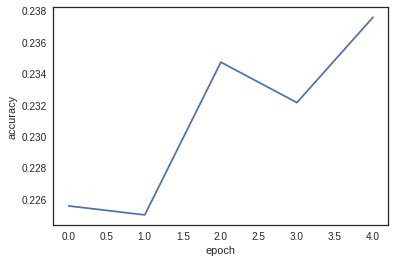

In [32]:
## visualize training process across epochs
# (sourced from lab)

# plot acc vs epoch
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

**Tuning InceptionV3 Pre-Trained Model:**

In [12]:
train_x_large = np.resize(train_x, (7000, 3, 48, 48))
train_x_large = train_x_large.reshape(7000, 48, 48, 3)
test_x_large = np.resize(test_x, (len(test_x), 3, 48, 48))
test_x_large = test_x_large.reshape(len(test_x), 48, 48, 3)

In [13]:
## load base model
# (sourced from https://keras.io/applications/)

# load base model
base_model = VGG16(weights = 'imagenet',
                         include_top = False,
                         input_shape = (48, 48, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(1024, 
          activation='relu')(x)

# add logistic layer
predictions = Dense(7, 
                    activation='softmax')(x)

# create model
model = Model(inputs = base_model.input, 
              outputs = predictions)

# freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# initially compile and fit model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

model.fit(train_x_large, train_y,
          batch_size = 500,
          epochs = 5,
          verbose = 1,
          validation_data = (test_x_large, test_y))

Train on 7000 samples, validate on 2200 samples
Epoch 1/5
 500/7000 [=>............................] - ETA: 475s - loss: 2.0900 - acc: 0.1660

KeyboardInterrupt: 